In [3]:
import sys
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget, QPushButton
import numpy as np
from queue import PriorityQueue
import time
import math

In [ ]:
# grid size and initialize a grid of zeros. We also set the starting location for the robot (start) and define locations for buildings, houses, and vehicles.

In [4]:
# Define the grid size and create a grid
grid_size = 15
grid = np.zeros((grid_size, grid_size))

In [5]:
# Define start location for the robot
start = (0, 0)
current_location = start

In [6]:
# Define locations for buildings, houses, delivery points, and vehicles
buildings = [(2, 3), (4, 5), (6, 8)]
houses = [(10, 12), (2, 7)]
vehicles = [(5, 10), (10, 6)]

In [7]:
# This section generates random delivery points on the grid, ensuring they do not overlap with buildings, houses, or other delivery points.
# Generate delivery points randomly
num_delivery_points = 5
delivery_points = []
for _ in range(num_delivery_points):
    x = np.random.randint(grid_size)
    y = np.random.randint(grid_size)
    while (x, y) in buildings or (x, y) in houses or (x, y) in delivery_points:
        x = np.random.randint(grid_size)
        y = np.random.randint(grid_size)
    delivery_points.append((x, y))

In [8]:
# Mark buildings, houses, delivery points, and vehicles on the grid
for building in buildings:
    grid[building[0], building[1]] = 1

for house in houses:
    grid[house[0], house[1]] = 2

for point in delivery_points:
    grid[point[0], point[1]] = 3

for vehicle in vehicles:
    grid[vehicle[0], vehicle[1]] = 4

In [9]:
#calculate random cost b/w (1,20)
def random_cost(current, next):
    return np.random.randint(1, 21)  # Random cost between 1 and 20

In [10]:
#This get_neighbors function is used to find neighboring cells around a given cell current

def get_neighbors(current, grid):
    neighbors = []
    x, y = current
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx != 0 or dy != 0:
                if 0 <= x + dx < len(grid) and 0 <= y + dy < len(grid[0]) and grid[x + dx][y + dy] != 1:
                    neighbors.append((x + dx, y + dy))
    return neighbors

In [11]:
def heuristic(current, goal):
    x1, y1 = current
    x2, y2 = goal
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)    

In [13]:
# Define A* Search algorithm
def a_star_search(start, goal, grid):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            break

        for next in get_neighbors(current, grid):
            new_cost = cost_so_far[current] + random_cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = new_cost + heuristic(next, goal)
                frontier.put(next, priority)
                came_from[next] = current

    return came_from
    

In [14]:
# Define Best First Search algorithm
def best_first_search(start, goal, grid):
    frontier = PriorityQueue()
    frontier.put(start, 0)
    came_from = {}
    cost_so_far = {}
    came_from[start] = None
    cost_so_far[start] = 0

    while not frontier.empty():
        current = frontier.get()

        if current == goal:
            break

        for next in get_neighbors(current, grid):
            new_cost = cost_so_far[current] + random_cost(current, next)
            if next not in cost_so_far or new_cost < cost_so_far[next]:
                cost_so_far[next] = new_cost
                priority = heuristic(next, goal)
                frontier.put(next, priority)
                came_from[next] = current

    return came_from

In [15]:

# The find_path_to_delivery_points function is responsible for finding paths from a starting location to each delivery point using both the Best First Search and A* Search algorithms.


def find_path_to_delivery_points(start, delivery_points, grid):
    paths_to_points_best_first = {}
    paths_to_points_a_star = {}
    current_location = start
    
    for idx, point in enumerate(delivery_points):
        # Best First Search
        came_from_best_first = best_first_search(current_location, point, grid)
        path_best_first = []
        current_best_first = point
        while current_best_first != current_location:
            path_best_first.append(current_best_first)
            current_best_first = came_from_best_first[current_best_first]
        path_best_first.append(current_location)
        path_best_first.reverse()
        paths_to_points_best_first[idx + 1] = path_best_first
        current_location = point
        
        # A* Search
        came_from_a_star = a_star_search(current_location, point, grid)
        path_a_star = []
        current_a_star = point
        while current_a_star != current_location:
            path_a_star.append(current_a_star)
            current_a_star = came_from_a_star[current_a_star]
        path_a_star.append(current_location)
        path_a_star.reverse()
        paths_to_points_a_star[idx + 1] = path_a_star
        current_location = point
    
    # Compare paths and choose the best one based on your criteria
    best_path = None
    best_algorithm = None
    shortest_length = float('inf')  # Initialize with a large value

    for algorithm, path in paths_to_points_best_first.items():
        if len(path) < shortest_length:
            shortest_length = len(path)
            best_path = path
            print(paths_to_points_a_star)
            best_algorithm = 'Best First Search'

    for algorithm, path in paths_to_points_a_star.items():
        if len(path) < shortest_length:
            shortest_length = len(path)
            best_path = path
            best_algorithm = 'A* Search'

    return paths_to_points_best_first, paths_to_points_a_star, best_path, best_algorithm



{1: [(0, 1)], 2: [(14, 13)], 3: [(10, 14)], 4: [(12, 8)], 5: [(13, 0)]}
Best path with length 2
Best path with length 23
Best path with length 10
Best path with length 9
Best path with length 10


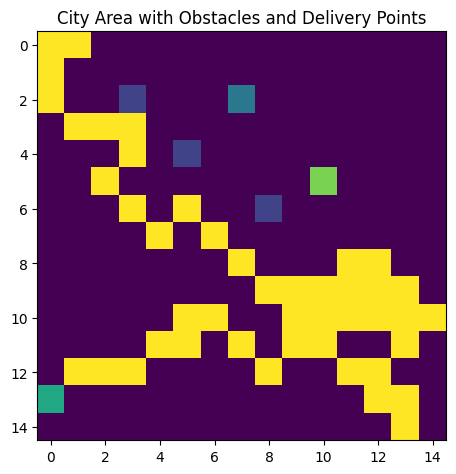

In [16]:

class RobotMovementWindow(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle('Robot Movement Visualization')
        self.setGeometry(100, 100, 800, 600)

        # Create a Matplotlib figure and canvas
        self.figure, self.ax = plt.subplots()
        self.canvas = FigureCanvas(self.figure)

        # Create a button to start the robot movement animation
        self.start_button = QPushButton('Start Robot Movement', self)
        self.start_button.clicked.connect(self.animate_robot_movement)

        # Create a vertical layout for the widgets
        layout = QVBoxLayout()
        layout.addWidget(self.canvas)
        layout.addWidget(self.start_button)

        # Create a central widget to set the layout
        central_widget = QWidget()
        central_widget.setLayout(layout)
        self.setCentralWidget(central_widget)

        # Visualize the initial grid
        self.update_grid()
        
    def update_grid(self):
        self.ax.clear()
        self.ax.imshow(grid, cmap='viridis', interpolation='nearest')
        self.ax.set_title('City Area with Obstacles and Delivery Points')
        self.canvas.draw()

    def animate_robot_movement(self):
        # Call the find_path_to_delivery_points method to get paths
        paths_to_delivery_points = find_path_to_delivery_points(current_location, delivery_points, grid)
        paths_best_first, paths_a_star,best_path,algo = paths_to_delivery_points

        for idx in paths_best_first:
            path_best_first = paths_best_first[idx]
            path_a_star = paths_a_star[idx]
            self.update_grid()

            # Update the grid visualization with the best path
            for i in range(len(path_best_first) - 1):
                x1, y1 = path_best_first[i]
                x2, y2 = path_best_first[i + 1]
                grid[x1, y1] = 5  # Mark the current cell as visited
                grid[x2, y2] = 4  # Mark the next cell as the robot's current location
                self.update_grid()  # Update the grid visualization
                QApplication.processEvents()  # Allow the GUI to update
                time.sleep(0.5)  # Pause for visualization (adjust as needed)

            # Update the current location of the robot to the final delivery point
            self.current_location = path_best_first[-1]
            grid[self.current_location[0], self.current_location[1]] = 3  # Mark the final cell as the delivery point
            self.update_grid()  # Update the grid visualization
            QApplication.processEvents()  # Allow the GUI to update
            time.sleep(1)  # Pause for visualization (adjust as needed)

            # Print or display the best algorithm and path information
            print(f"Best path with length {len(path_best_first)}")
# Create the PyQt5 application and window
app = QApplication(sys.argv)
window = RobotMovementWindow()
window.show()
app.exec_()
app.exit()
# sys.exit(app.exec_())